In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
#machine learning
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
# machine learning
from sklearn.naive_bayes import MultinomialNB,GaussianNB

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv('disaster_tweets.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Target Distribution

<Axes: ylabel='count'>

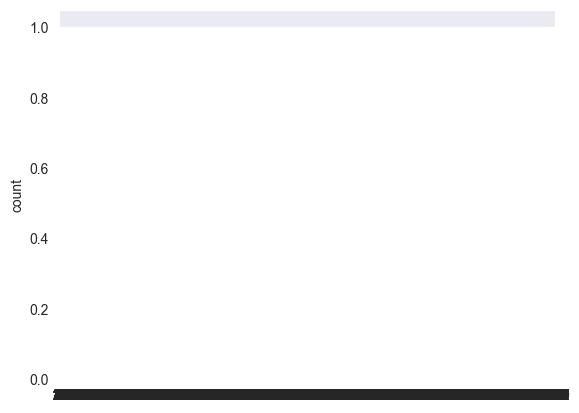

In [4]:
sns.set_style("dark")
sns.countplot(df.target)

In [15]:
# craeteing new column for storing length of reviews 
df['length'] = df['text'].apply(len)
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


<Axes: ylabel='Frequency'>

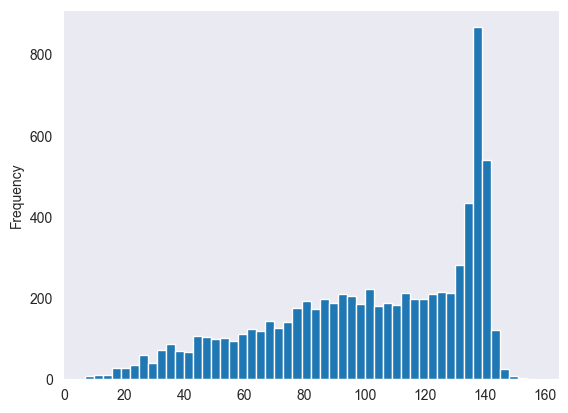

In [16]:
df['length'].plot(bins=50, kind='hist')

In [17]:
df.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [18]:
df[df['length'] == 157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

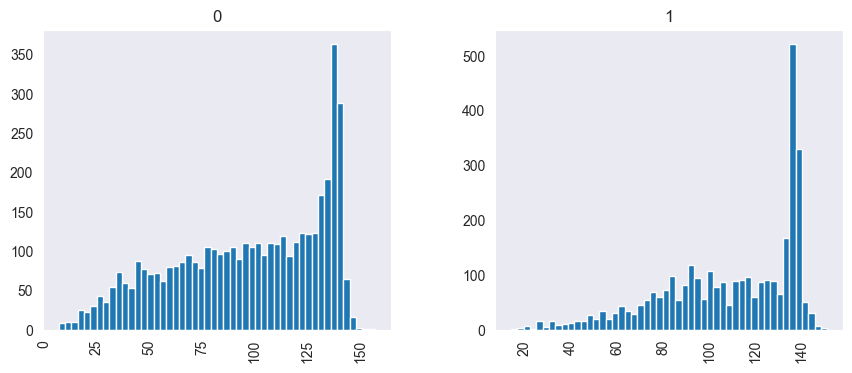

In [11]:
df.hist(column='length', by='target', bins=50,figsize=(10,4))

In [19]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from headline news
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df_1 = df[df['target']==1]
df_0 = df[df['target']==0]
df_1['text']=df_1['text'].apply(remove_stopwords)
df_0['text']=df_0['text'].apply(remove_stopwords)

C:\Users\Asus\AppData\Local\Temp\ipykernel_23560\3205113125.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['text']=df_1['text'].apply(remove_stopwords)
C:\Users\Asus\AppData\Local\Temp\ipykernel_23560\3205113125.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['text']=df_0['text'].apply(remove_stopwords)


## Plotting wordcloud of Disaster Tweets

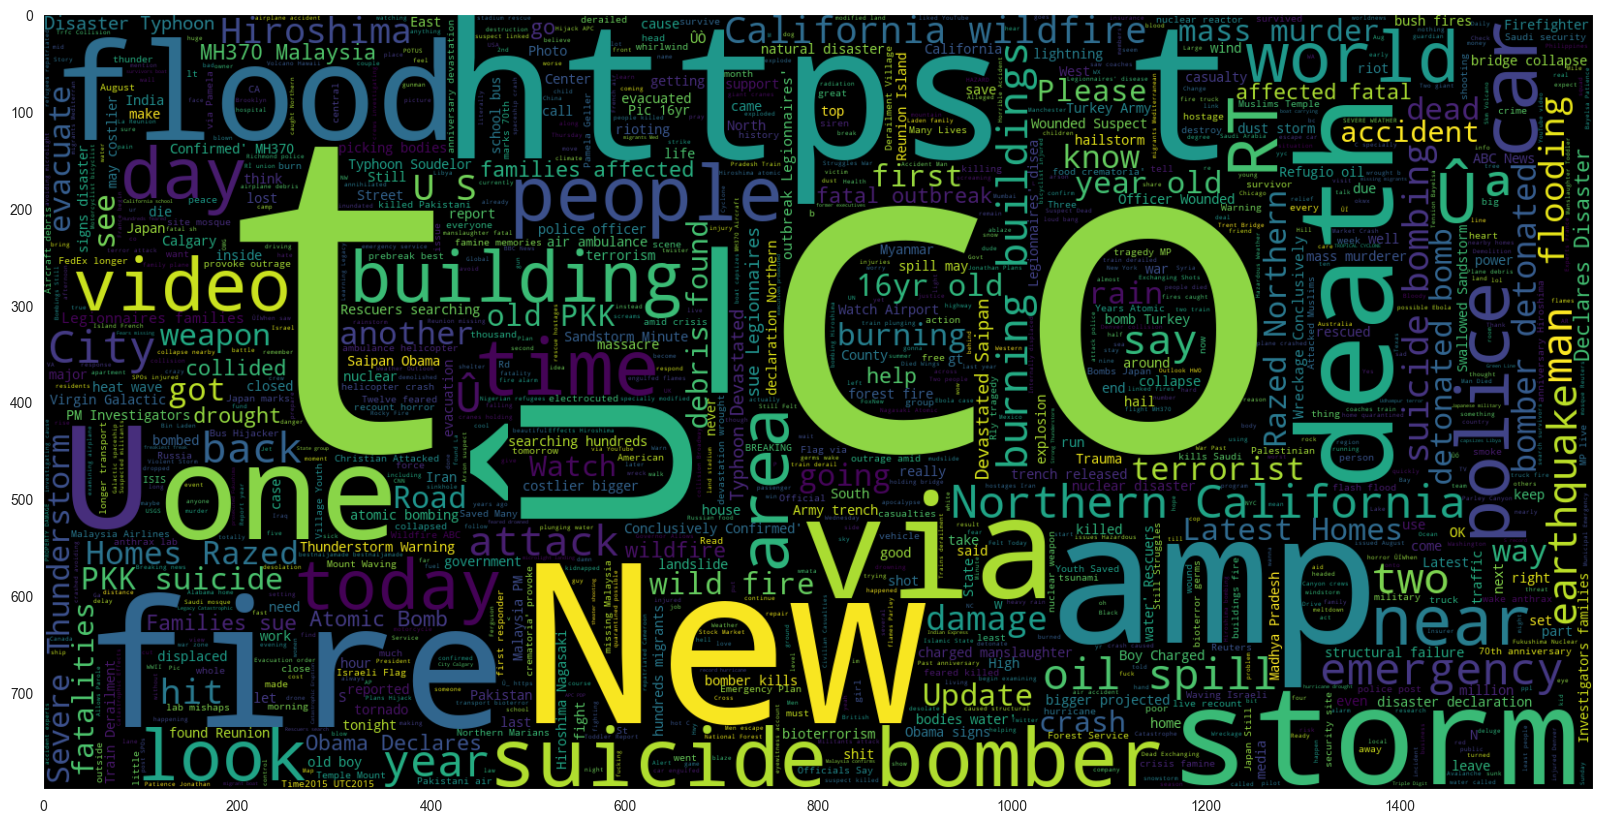

In [20]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Disaster tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_1.text))
plt.imshow(wc , interpolation = 'bilinear')


## Plotting wordcloud of Normal Tweets

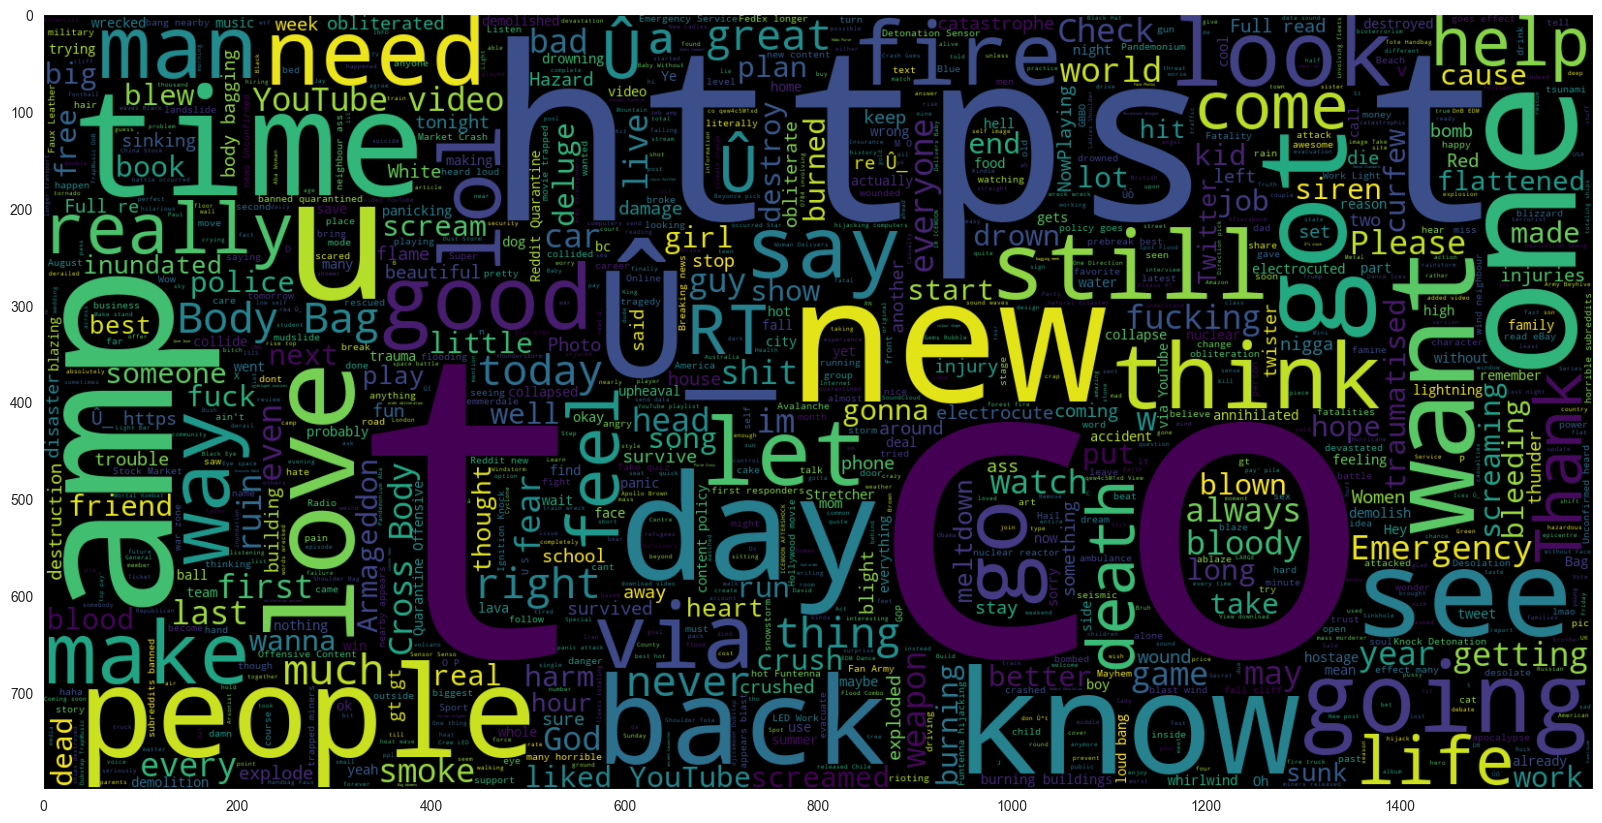

In [21]:
plt.figure(figsize = (20,20)) # Text that is Normal Tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_0.text))
plt.imshow(wc , interpolation = 'bilinear')

## Data Cleaning and Preparation

In [25]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
#creating list of possible stopwords from nltk library
stop = stopwords.words('english')

def cleanTweet(txt):
  # lowercaing
    txt = txt.lower()
    # tokenization
    words = nltk.word_tokenize(txt)
  # removing stopwords & mennatizing the words
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in (stop)])
    text = "".join(words)
  # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',text)
    return txt  


## Applying Clean Tweet Function on Tweets Text

In [26]:
df['cleaned_tweets'] = df['text'].apply(cleanTweet)
df.head()

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\Asus/nltk_data'
    - 'c:\\Users\\Asus\\AppData\\Local\\Programs\\Python\\Python310\\nltk_data'
    - 'c:\\Users\\Asus\\AppData\\Local\\Programs\\Python\\Python310\\share\\nltk_data'
    - 'c:\\Users\\Asus\\AppData\\Local\\Programs\\Python\\Python310\\lib\\nltk_data'
    - 'C:\\Users\\Asus\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


## Creating Feature & Target Variables

In [23]:
y = df.target
X=df.cleaned_tweets

AttributeError: 'DataFrame' object has no attribute 'cleaned_tweets'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

## TF-IDF Vectorizer - Bi-Gram

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Multinomial Naive Bayes

In [ ]:
## Model Fitting
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)



MultinomialNB()

## 10-Fold Cross Validation

In [ ]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb2 = cross_val_score(estimator = mnb_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_mnb2.mean()

0.7922824302134648

## Model Prediction Test set

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.7338


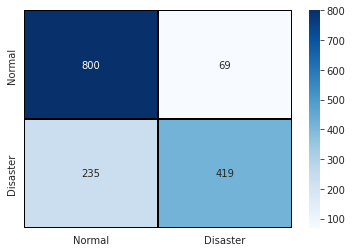

In [ ]:
pred_mnb2 = mnb_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_mnb2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)

acc= accuracy_score(y_test, pred_mnb2)

prec = precision_score(y_test, pred_mnb2)
rec = recall_score(y_test, pred_mnb2)
f1 = f1_score(y_test, pred_mnb2)


model_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])

model_results

## Passive Aggressive Classifier

In [ ]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)

PassiveAggressiveClassifier()

## 10-Fold Cross Validation

In [ ]:

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass2 = cross_val_score(estimator = pass_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_pass2.mean()

0.786863711001642

## Model Prediction

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.790545,0.758887,0.750765,0.920598,0.754804


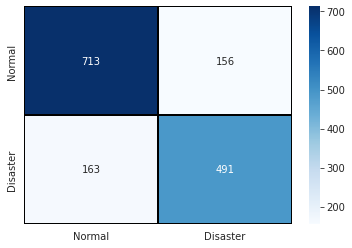

In [ ]:
pred_pass2 = pass_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_pass2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_pass2)
prec = precision_score(y_test, pred_pass2)
rec = recall_score(y_test, pred_pass2)
f1 = f1_score(y_test, pred_pass2)

results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = model_results.append(results, ignore_index = True)
results

## TF-IDF Vectorizer - Tri Gram

In [ ]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer_3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer_3.transform(X_test)

## Multinomial Naive Bayes - Tri Gram

In [ ]:
mnb_tf3 = MultinomialNB()
mnb_tf3.fit(tfidf_train_3, y_train)

MultinomialNB()

## 10-fold cross validation

In [ ]:
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb3 = cross_val_score(estimator = mnb_tf, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_mnb3.mean()

0.7845648604269294

## Model Prediction

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.790545,0.758887,0.750765,0.920598,0.754804
2,Multinomial Naive Bayes - TFIDF-Trigram,0.798424,0.866808,0.626911,0.920598,0.727595


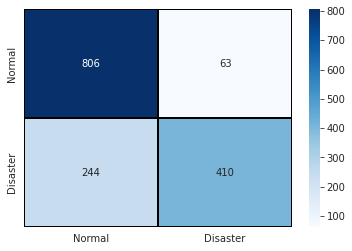

In [ ]:
pred_mnb3 = mnb_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_mnb3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_mnb3)
prec = precision_score(y_test, pred_mnb3)
rec = recall_score(y_test, pred_mnb3)
f1 = f1_score(y_test, pred_mnb3)

mod_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(mod_results, ignore_index = True)
results

## Passive Aggressive Classifier - Tri Gram

In [ ]:
pass_tf3 = PassiveAggressiveClassifier()
pass_tf3.fit(tfidf_train_3, y_train)

## cross validation
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass3 = cross_val_score(estimator = pass_tf3, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_pass3.mean()

0.7937602627257799

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.790545,0.758887,0.750765,0.920598,0.754804
2,Multinomial Naive Bayes - TFIDF-Trigram,0.798424,0.866808,0.626911,0.920598,0.727595
3,Passive Aggressive Classifier - TFIDF-Trigram,0.783322,0.740356,0.762997,0.920598,0.751506


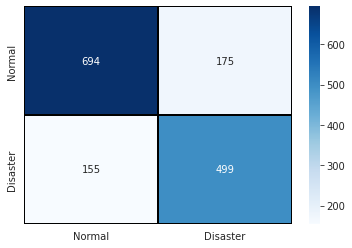

In [ ]:
pred_pass3 = pass_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_pass3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_pass3)
prec = precision_score(y_test, pred_pass3)
rec = recall_score(y_test, pred_pass3)
f1 = f1_score(y_test, pred_pass3)

mod1_results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(mod1_results, ignore_index = True)
results

## Most Informative Features

In [ ]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [ ]:
most_informative_feature_for_binary_classification(tfidf_vectorizer_3, pass_tf3, n=10)

0 -2.266591436407435 let
0 -2.0972631305171663 love
0 -1.9203808315650845 suicide bomb
0 -1.8505651293758023 new
0 -1.8458355317244797 flattened
0 -1.825227639590395 bag
0 -1.8049218730099583 traumatised
0 -1.7751185871760702 hrqcjdovjz
0 -1.7751185871760702 http hrqcjdovjz
0 -1.7751185871760702 mishap http hrqcjdovjz

1 4.057632105996396 hiroshima
1 3.8588099170606402 http
1 3.563754533274007 california
1 3.1433370153529676 bombing
1 3.0338317777168773 train
1 2.966675456601155 building
1 2.8861248644927997 wildfire
1 2.849790628152346 forest
1 2.8032814773887966 flood
1 2.631449762986132 japan


In [ ]:
most_informative_feature_for_binary_classification(tfidf_vectorizer, mnb_tf, n=10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


0 -11.180922536489286 aa mgm
0 -11.180922536489286 aaaa
0 -11.180922536489286 aaaa ok
0 -11.180922536489286 aamir
0 -11.180922536489286 aamir javaid
0 -11.180922536489286 aannnnd
0 -11.180922536489286 aannnnd reddit
0 -11.180922536489286 aar
0 -11.180922536489286 aar ambulance
0 -11.180922536489286 aatt

1 -6.6560498687234295 http
1 -8.387208121290184 news
1 -8.464684612463378 california
1 -8.492627951161609 family
1 -8.535487626988232 disaster
1 -8.549722346224069 suicide
1 -8.611859274565505 train
1 -8.629174350014052 building
1 -8.636480964167959 home
1 -8.648206604075396 hiroshima


## Sample prediction

In [ ]:
sentences = [
  "Just happened a terrible car crash",
    "Heard about #earthquake is different cities, stay safe everyone.",
    "No I don't like cold!",
    "@RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated?"
  ]

tfidf_trigram = tfidf_vectorizer_3.transform(sentences)


predictions = pass_tf3.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label==1:
        target="Disaster Tweet"
        print("text:", text, "\nClass:", target)
        print()
    else:
        target="Normal Tweet"
        print("text:", text, "\nClass:", target)
        print()

text: Just happened a terrible car crash 
Class: Disaster Tweet

text: Heard about #earthquake is different cities, stay safe everyone. 
Class: Disaster Tweet

text: No I don't like cold! 
Class: Normal Tweet

text: @RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated? 
Class: Normal Tweet

